In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

# load dataset and show the first run
case1run1 = pd.read_csv('./mill_data/case1run1.csv')
case1run2 = pd.read_csv('./mill_data/case1run2.csv')
columns=['case', 'run', 'VB', 'time', 'doc','feed','material','smcAC', 'smcDC', 'vib_table', 'vib_spindle', 'AE_table', 'AE_spindle']
case1run1.columns = columns
case1run2.columns = columns

In [2]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing, metrics
from ipywidgets import widgets, interactive
import gc
import joblib
import glob
import os
import warnings
from datetime import datetime, timedelta
from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm
from itertools import cycle
import datetime as dt
from torch.autograd import Variable
import random
from matplotlib.pyplot import figure
import torch
import torch.nn as nn
from copy import deepcopy
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error



warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

from lstm_attention import lstmattention

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
# load dataset and show the first run
case1run1 = pd.read_csv('./mill_data/case1run1.csv')
case1run2 = pd.read_csv('./mill_data/case1run2.csv')
columns=['case', 'run', 'VB', 'time', 'doc','feed','material','smcAC', 'smcDC', 'vib_table', 'vib_spindle', 'AE_table', 'AE_spindle']
case1run1.columns = columns
case1run2.columns = columns

nan

In [5]:
str(case1run2['VB'][0])=='nan'

True

In [7]:
def sliding_windows(data, seq_length):
    x = []
    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        x.append(_x)

    return np.array(x)

In [8]:
def labeling(data,seq_length,lab):
    x = []
    for i in range(len(data)-seq_length-1):
        x.append(lab)

    return np.array(x)

In [10]:
path = './mill_data/'
file_list = os.listdir(path)

In [33]:
def to_dataset(data,label):
    smcAC=np.expand_dims(sliding_windows(data['smcAC'][3000:-3000],24),axis=2)
    smcDC=np.expand_dims(sliding_windows(data['smcDC'][3000:-3000],24),axis=2)
    vib_table=np.expand_dims(sliding_windows(data['vib_table'][3000:-3000],24),axis=2)
    vib_spindle=np.expand_dims(sliding_windows(data['vib_spindle'][3000:-3000],24),axis=2)
    AE_table=np.expand_dims(sliding_windows(data['AE_table'][3000:-3000],24),axis=2)
    AE_spindle=np.expand_dims(sliding_windows(data['AE_spindle'][3000:-3000],24),axis=2)
    xdata = np.concatenate((smcAC,smcDC,vib_table,vib_spindle,AE_table,AE_spindle),axis=2)
    ydata = labeling(data[3000:-3000],24, label)
    return xdata,ydata

In [41]:
def to_casedataset(data_list):
    empty_x=np.zeros(((1, 24, 6)))
    empty_y=np.zeros(((1)))

    for i in data_list:
        pdd=pd.read_csv('./mill_data/'+i)
        pdd.columns = columns
        lab=pdd['VB'][0]
        if str(lab)!='nan':
            x_,y_=to_dataset(pdd,lab)
            empty_x=np.concatenate((empty_x,x_),axis=0)
            empty_y=np.concatenate((empty_y,y_),axis=0)
    
    return empty_x[1:],empty_y[1:]

In [42]:
case1list=[file for file in file_list if file.startswith('case1run')]
case9list=[file for file in file_list if file.startswith('case9run')]

In [43]:
c1_x,c1_y=to_casedataset(case1list)

In [44]:
c9_x,c9_y=to_casedataset(case9list)

In [48]:
class SequenceDataset(Dataset):
    def __init__(self, x, y):
        self.x=x
        self.y=y
        
    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i): 
        data=self.x[i]
        label=self.y[i]

        return data,label

In [49]:
c1_x = Variable(torch.Tensor(np.array(c1_x)))
c1_y = Variable(torch.Tensor(np.array(c1_y)))
c9_x = Variable(torch.Tensor(np.array(c9_x)))
c9_y = Variable(torch.Tensor(np.array(c9_y)))


print("train shape is:",c1_x.size())
print("train label shape is:",c1_y.size())
print("test shape is:",c9_x.size())
print("test label shape is:",c9_y.size())

train shape is: torch.Size([38662, 24, 6])
train label shape is: torch.Size([38662])
test shape is: torch.Size([26766, 24, 6])
test label shape is: torch.Size([26766])


In [50]:
c1_dataset=SequenceDataset(c1_x,c1_y)
c9_dataset=SequenceDataset(c9_x,c9_y)

In [51]:
from torch.utils.data import DataLoader
torch.manual_seed(99)

train_loader = DataLoader(c1_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(c9_dataset, batch_size=1, shuffle=False)


In [82]:
learning_rate = 5e-5
N_HIDDENS = 200
N_LAYERS = 3
epoch = 50
model = lstmattention()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [83]:
from copy import deepcopy
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = torch.sqrt(loss_function(output, y))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    return avg_loss

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += torch.sqrt(loss_function(output, y)).item()

    avg_loss = total_loss / num_batches
    return avg_loss

In [84]:

print("Untrained test")
print(test_model(test_loader, model, loss_function))
best_fitness = -100000


Untrained test
0.6248393455250403


run: 0


RuntimeError: The size of tensor a (6) must match the size of tensor b (32) at non-singleton dimension 1

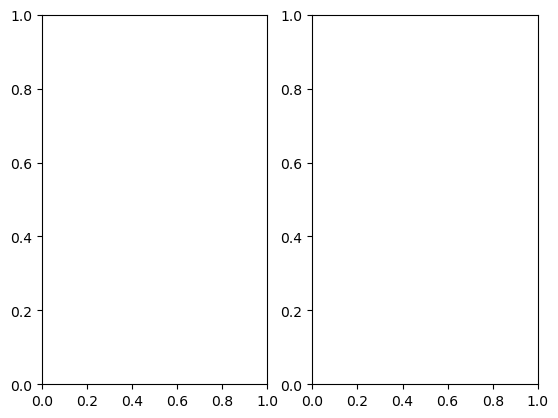

In [85]:
fig, axs = plt.subplots(1, 2)
for epoch in range(30):
    print("run:", epoch)
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, model, loss_function)
    print("train_loss:",train_loss)
    print("test_loss:",test_loss)
    axs[0].scatter(epoch, train_loss, color='g')
    axs[1].scatter(epoch, test_loss, color='r')
    fitness = -test_loss
    if fitness > best_fitness:
        best_fitness = fitness
        best_model = deepcopy(model)

In [70]:
def inference(data_loader, model):

    model.eval()
    with torch.no_grad():
        for count, (X, y) in enumerate(data_loader):
            output = model(X)
            plt.scatter(count, output[0].numpy(), color='g')
            plt.scatter(count, y[0].numpy(), color='r')
    plt.show()

In [71]:
test_loader = DataLoader(c9_dataset, batch_size=1, shuffle=False)
print('Predictions on test set')

Predictions on test set


In [72]:
inference(test_loader, best_model)
print('Predictions on train set')


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x000001F9CED57040> (for post_execute):



KeyboardInterrupt



Error in callback <function flush_figures at 0x000001F9D8BFEAF0> (for post_execute):



KeyboardInterrupt



In [ ]:
train_loader = DataLoader(c1_dataset, batch_size=1, shuffle=False)
inference(train_loader, best_model)

In [75]:
def test_model2(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    a=[]
    b=[]
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += torch.sqrt(loss_function(output, y)).item()
            a.append(y)
            b.append(output)

    avg_loss = total_loss / num_batches
    return avg_loss,a,b

In [82]:
test_loader = DataLoader(c9_dataset, batch_size=32, shuffle=False)
print('Predictions on test set')

Predictions on test set


In [83]:
c,v,n=test_model2(test_loader, model, loss_function)

In [84]:
q,w=[],[]
for i in range(len(v)):
    q.append(sum(v[i])/len(v[i]))
    w.append(sum(n[i])/len(n[i]))

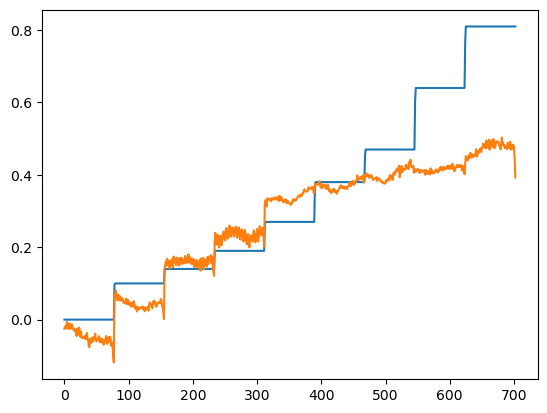

In [86]:
plt.plot(q)
plt.plot(w)

In [74]:
train_loader = DataLoader(c1_dataset, batch_size=32, shuffle=False)
print('Predictions on train set')

Predictions on train set


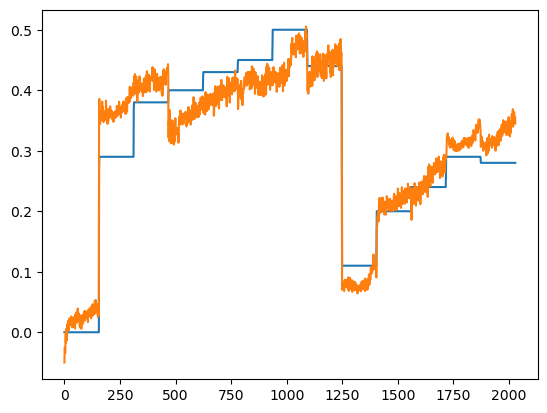

In [88]:
c,v,n=test_model2(train_loader, model, loss_function)
q,w=[],[]
for i in range(len(v)):
    q.append(sum(v[i])/len(v[i]))
    w.append(sum(n[i])/len(n[i]))
    
plt.plot(q)
plt.plot(w)